In [77]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import torch

In [78]:
# Load the pre-trained ChatGPT model and tokenizer
model_name = "EleutherAI/gpt-neo-125M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

# Put it on gpu
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [79]:
# Load the VADER sentiment lexicon
analyzer = SentimentIntensityAnalyzer()

In [135]:
df_orig = pd.read_csv('twitter_validation.csv', names=["Twitter ID","Topic","Sentiment","Text"])
df = df_orig.iloc[0:1000]
df

,Twitter ID,Topic,Sentiment,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [136]:
# Preprocessing (delete username and url)
def preprocess(text):
    temp = []

    for t in text.split(" "): # split a sentence into words by spaces " ".
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        temp.append(t)
    return " ".join(temp)

# Change Irrelevant label into Neutral as mentioned in the data set description.
def adjust_ori_sentiment(sentiment):
    if sentiment == "Irrelevant":
        temp_str = "Neutral"
        return temp_str
    else:
        return sentiment

In [137]:
df['Text'] = df['Text'].apply(preprocess)
df['Sentiment'] = df['Sentiment'].apply(adjust_ori_sentiment)
df

,Twitter ID,Topic,Sentiment,Text
0,3364,Facebook,Neutral,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@user Why do I pay for WORD when it functions ...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Neutral,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Neutral,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [138]:
def textlabel(tweet):
    # Preprocess the tweet and use ChatGPT to extract keywords or phrases
    inputs = tokenizer.encode(tweet, return_tensors="pt").to(device)
    outputs = model.generate(inputs, max_new_tokens=100, do_sample=True, temperature=x, pad_token_id=tokenizer.eos_token_id)
    generated_tweet = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_tokens = nltk.word_tokenize(generated_tweet.lower())
    #print("Assigning scores...")
    # Assign sentiment scores using the VADER sentiment lexicon
    scores = []
    for token in generated_tokens:
        score = analyzer.polarity_scores(token)
        scores.append(score["compound"])

    # Calculate the overall sentiment score for the tweet
    overall_score = sum(scores) / len(scores)

    # Determine the sentiment polarity of the tweet
    if overall_score > 0:
        return 'Positive'
    elif overall_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Check the accuracy
def evalable(label):
    good_label = 0
    bad_label= 0
    for i in range (df.shape[0]):
        if str(df.iloc[i,2]) == str(df.iloc[i,4]):
            good_label += 1
        else:
            bad_label += 1
    return good_label, bad_label

In [84]:
x_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
acc_list = []
for i in range(len(x_list)):
    x = x_list[i]
    df['results'] = df['Text'].apply(textlabel)
    acc_list.append(evalable(df))

In [86]:
x_list2 = [0.2, 0.3, 0.35, 0.4, 0.45]
acc_list2 = []
for i in range(len(x_list2)):
    x = x_list2[i]
    df['results'] = df['Text'].apply(textlabel)
    acc_list2.append(evalable(df))

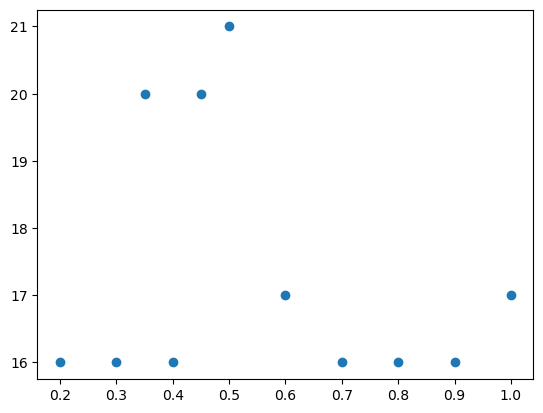

In [133]:
mid_acc_list = acc_list+acc_list2
f_temp_list = x_list+x_list2

f_acc_list = []
for i in range(len(mid_acc_list)):
    f_acc_list.append(mid_acc_list[i][0])

plt.plot(f_temp_list, f_acc_list, 'o')

In [139]:
x = 0.5
df['results'] = df['Text'].apply(textlabel)
acc_list.append(evalable(df))

In [141]:
acc_list

[(21, 29), (17, 33), (16, 34), (16, 34), (16, 34), (17, 33), (368, 632)]